In [45]:
# --- Python Module Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
import re

In [46]:
"""
Description: Extracts the string as a column name after the closing parenthesis
and before the opening parenthesis if 1 exists

Arguments:
  currentLine(string): Line to extract string

Returns:
  newLine(string): Name of column extracted from line of text
"""
def extractColumnName(currentLine):
  openingParenIndex = currentLine.find(")") + 1
  if "(" in currentLine:
    closingParenIndex = currentLine.find("(")
    newLine = currentLine[openingParenIndex:closingParenIndex].strip()
  else:
    newLine = currentLine[openingParenIndex:].strip()
  return newLine

In [47]:
# Variable Initialization
columnNames = []
repColumnNames = []
pattern1 = r"^\d\)"
pattern2 = r"^[a-z]\)"
reachedLine = False

In [48]:
# Generate column names for dataset
with open('wdbc.names', 'r') as columnsFile:
  for line in columnsFile:
    matchedPattern = False
    if "Attribute information" in line:
      reachedLine = True
      continue
    if reachedLine:
      if len(line) > 3:
        newLine = line.strip()
        if re.match(pattern1, newLine):
          newLine = extractColumnName(newLine)
          columnNames.append(newLine)
        elif re.match(pattern2, newLine):
          newLine = extractColumnName(newLine)
          repColumnNames.append(newLine)

# Get numerical column names to use as column headers for table
for i in range(3):
  for columnName in repColumnNames:
    columnNames.append(columnName + str(i+1))

In [49]:
# Process data from Breast Cancer dataset file
dataSet = pd.read_csv('wdbc.data', delimiter=',', names=columnNames)
columnNames.remove('ID number')
dataSet = dataSet.drop('ID number', axis=1)

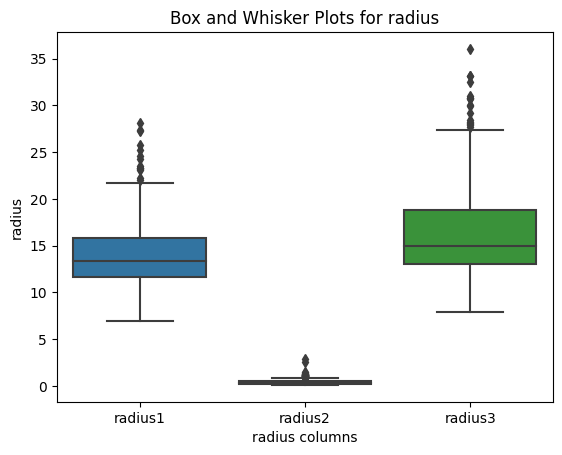

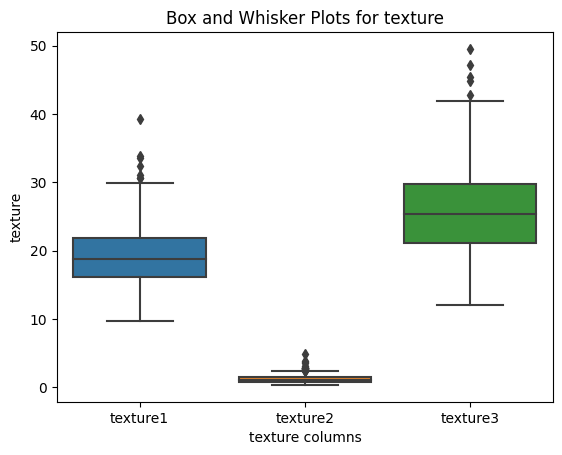

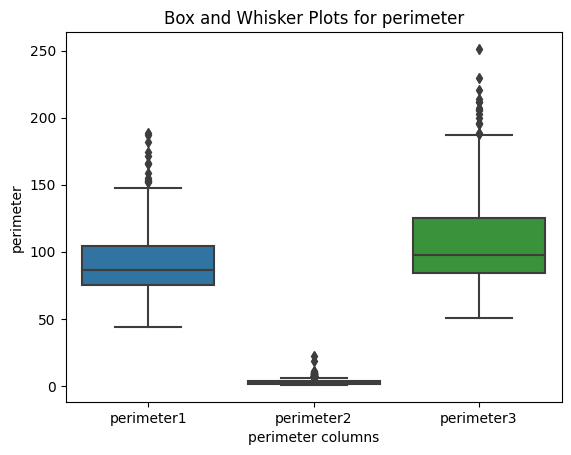

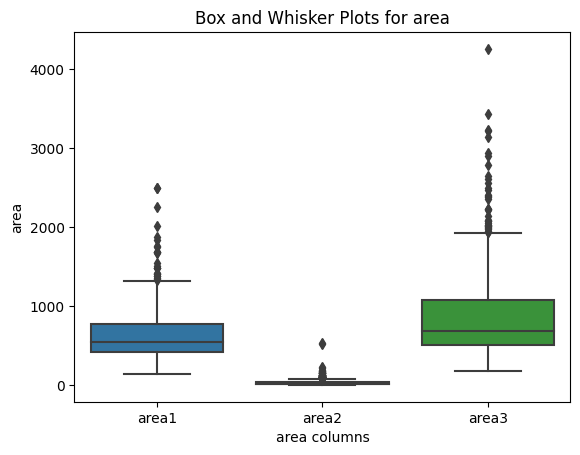

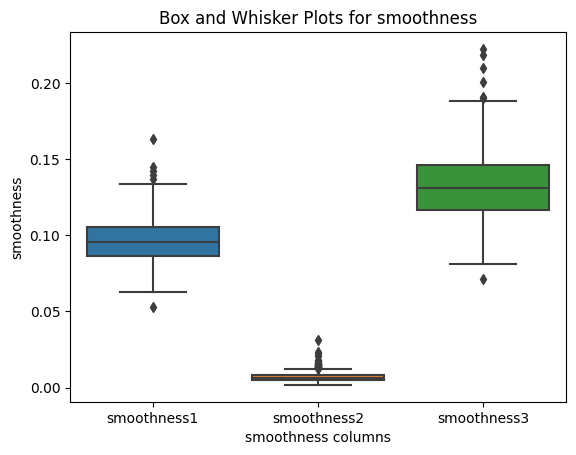

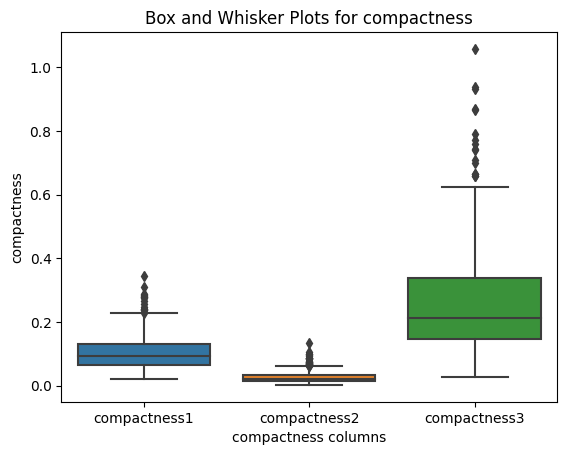

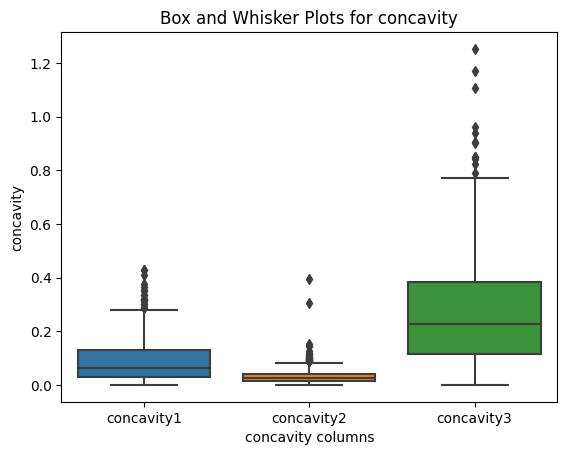

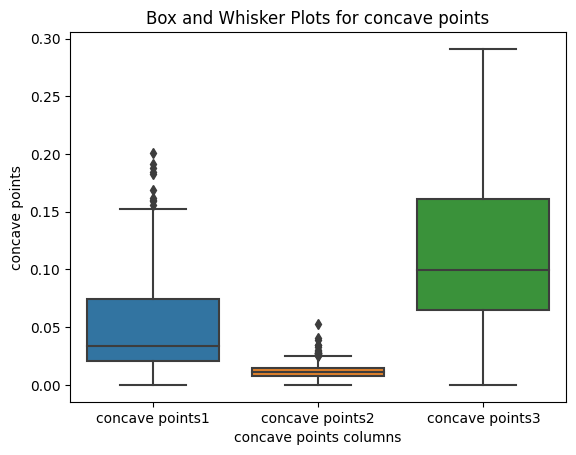

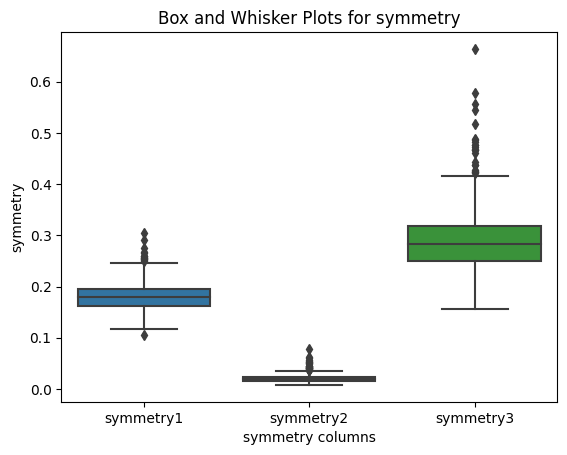

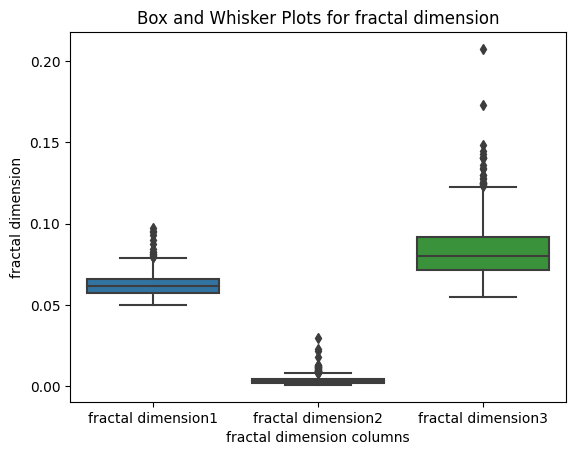

In [50]:
# Generate side-by-side box and whisper plots for each of the 10 repeated attributes in dataset
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
for columnName in repColumnNames:
  plotCols = []
  for i in range(3):
    plotCols.append(columnName + str(i+1))
  sns.boxplot(data=dataSet[plotCols])
  plt.title("Box and Whisker Plots for " + columnName)
  plt.xlabel(columnName + " columns")
  plt.ylabel(columnName)
  plt.show()

In [51]:
# Mean Imputation Using Mean Values of the Same Diagnosis Class
imputer = SimpleImputer()
imputeCols = dataSet.columns[1:31]
dataSetClasses = dataSet.groupby('Diagnosis')
dataSet['Original Order'] = range(len(dataSet))
imputedDataSet = pd.DataFrame()
for _, dataSetClass in dataSetClasses:
    imputedClass = dataSetClass
    imputedClass[imputeCols] = imputer.fit_transform(dataSetClass[imputeCols])
    imputedDataSet = imputedDataSet.append(imputedClass)
imputedDataSet.sort_values(by='Original Order', inplace=True)
imputedDataSet.drop(columns='Original Order', inplace=True)

<ipython-input-51-709e0ab1aec4>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  imputedDataSet = imputedDataSet.append(imputedClass)
<ipython-input-51-709e0ab1aec4>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  imputedDataSet = imputedDataSet.append(imputedClass)


In [52]:
# Changing Class Labels to Numerical Values
normLabels = LabelEncoder()
imputedDataSet['Diagnosis'] = normLabels.fit_transform(imputedDataSet['Diagnosis'])

In [53]:
# Using MinMaxScale on the data set shrinking the data range to [0,1]
scaler = MinMaxScaler()
imputedDataSet = scaler.fit_transform(imputedDataSet)
imputedDataSet = pd.DataFrame(imputedDataSet, columns=columnNames)

In [54]:
# Splitting features and target(in this case Diagnosis) of dataset
features = imputedDataSet.drop('Diagnosis', axis=1)
targetVar = imputedDataSet['Diagnosis']

In [93]:
# Splitting dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(features, targetVar, random_state=42, stratify=targetVar)

In [94]:
# Training k-Nearest Neighbors(k-NN) (where k is tested from 1-10) classifier to model dataset
knnClassifier = KNeighborsClassifier()
kRange = list(range(1, 11))
gridParams = {
    'n_neighbors': kRange
}
gridSearch = GridSearchCV(knnClassifier, gridParams, scoring='f1')
gridSearch.fit(X_train, y_train)


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='f1')

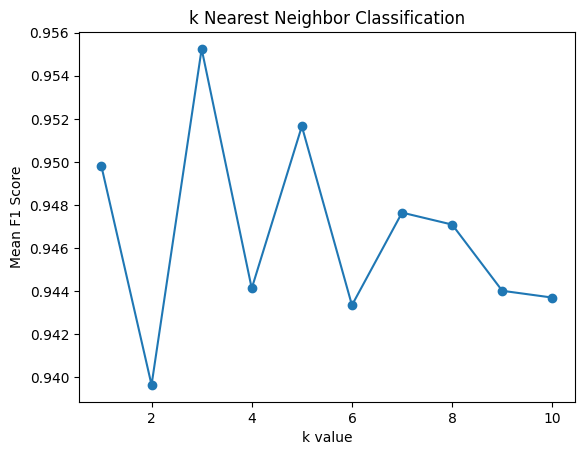

In [96]:
# Generate plot for Mean F1 Score
meanF1Scores = gridSearch.cv_results_['mean_test_score']
plt.plot(kRange, meanF1Scores, marker='o')
plt.xlabel("k value")
plt.ylabel("Mean F1 Score")
plt.title("k Nearest Neighbor Classification")
plt.show()

In [97]:
# Find best choice for k based on F1 score
kBest = gridSearch.best_params_
print("The best value for the k parameter is " + str(kBest['n_neighbors']))
print("Corresponding F1 score: " + str(gridSearch.best_score_))

The best value for the k parameter is 3
Corresponding F1 score: 0.9552432995055946
